In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pathlib

from sklearn.preprocessing import StandardScaler

import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data_dir = pathlib.Path("train")
print(train_data_dir)

test_data_dir = pathlib.Path("test")
print(test_data_dir)

In [3]:
# Khởi tạo ImageDataGenerator cho dữ liệu huấn luyện
train_data_gen = ImageDataGenerator(
        rescale=1./255,  # Scale giá trị các pixel về khoảng [0, 1]
        rotation_range=30,  # Góc xoay tối đa cho phép cho các ảnh
        width_shift_range=0.1,  # Phạm vi dịch chuyển ngang tối đa cho phép
        height_shift_range=0.1,  # Phạm vi dịch chuyển dọc tối đa cho phép
        shear_range=0.2,  # Phạm vi biến dạng cắt cho phép
        zoom_range=0.2,  # Phạm vi thu phóng cho phép
        horizontal_flip=True)  # Lật ngang ảnh theo xác suất 50%

# Khởi tạo ImageDataGenerator cho dữ liệu kiểm tra
validation_data_gen = ImageDataGenerator(rescale=1./255)  # Scale giá trị các pixel về khoảng [0, 1]

# Tạo generator cho dữ liệu huấn luyện
train_generator = train_data_gen.flow_from_directory(
        'train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Tạo generator cho dữ liệu kiểm tra
validation_generator = validation_data_gen.flow_from_directory(
        'test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Khởi tạo mô hình Sequential
emotion_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),  # Convolutional layer với 32 bộ lọc 3x3, hàm kích hoạt ReLU
    Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Convolutional layer với 64 bộ lọc 3x3, hàm kích hoạt ReLU
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer với cửa sổ 2x2
    Dropout(0.25),  # Lớp Dropout với tỷ lệ loại bỏ 0.25

    Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Convolutional layer với 128 bộ lọc 3x3, hàm kích hoạt ReLU
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer với cửa sổ 2x2
    Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Convolutional layer với 128 bộ lọc 3x3, hàm kích hoạt ReLU
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer với cửa sổ 2x2
    Dropout(0.25),  # Lớp Dropout với tỷ lệ loại bỏ 0.25

    Flatten(),  # Làm phẳng đầu ra của lớp trước để chuẩn bị cho lớp Fully Connected
    Dense(1024, activation='relu'),  # Lớp Fully Connected với 1024 nơ-ron, hàm kích hoạt ReLU
    Dropout(0.5),  # Lớp Dropout với tỷ lệ loại bỏ 0.5
    Dense(7, activation='softmax')  # Lớp Fully Connected cuối cùng với 7 nơ-ron (số lượng lớp đầu ra), hàm kích hoạt softmax
])

emotion_model.compile(optimizer='adam',  # Optimizer được sử dụng là Adam
              loss="categorical_crossentropy",  # Hàm mất mát sử dụng là categorical cross-entropy
              metrics=['accuracy'])  # Độ đo đánh giá là accuracy

emotion_model.summary()  # Hiển thị thông tin về kiến trúc của mô hình

# Huấn luyện mô hình
emotion_model_info = emotion_model.fit(
        train_generator,  # Dữ liệu huấn luyện từ generator
        steps_per_epoch=28709 // 64,  # Số bước huấn luyện trong mỗi epoch
        epochs=60,  # Số lượng epoch
        validation_data=validation_generator,  # Dữ liệu chứng thực từ generator
        validation_steps=7178 // 64)  # Số bước chứng thực trong mỗi epoch

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

In [5]:
print(emotion_model_info.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


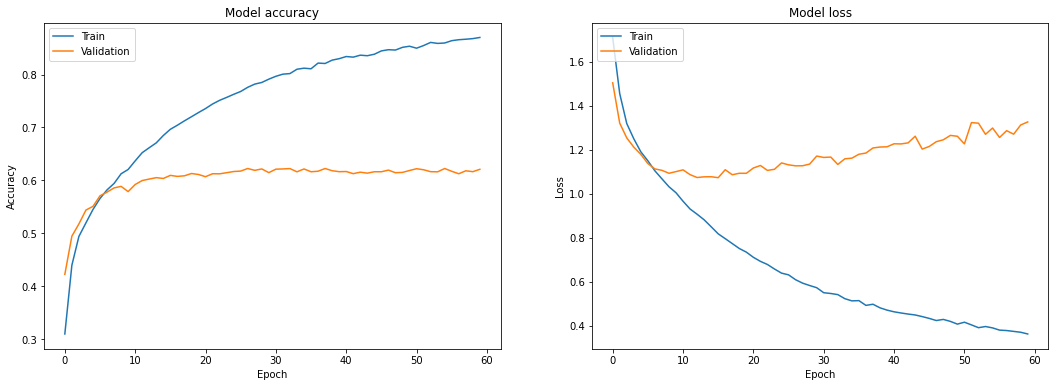

In [6]:
import matplotlib.pyplot as plt

# Tạo đối tượng hình ảnh với 1 hàng và 2 cột
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Vẽ đồ thị cho độ chính xác của mô hình trong quá trình huấn luyện
axes[0].plot(emotion_model_info.history['accuracy'])
axes[0].plot(emotion_model_info.history['val_accuracy'])
axes[0].set_title('Model accuracy')  # Đặt tiêu đề cho đồ thị
axes[0].set_ylabel('Accuracy')  # Đặt tên cho trục y
axes[0].set_xlabel('Epoch')  # Đặt tên cho trục x
axes[0].legend(['Train', 'Validation'], loc='upper left')  # Thêm chú thích cho các đường
# Vẽ đồ thị cho loss của mô hình trong quá trình huấn luyện
axes[1].plot(emotion_model_info.history['loss'])
axes[1].plot(emotion_model_info.history['val_loss'])
axes[1].set_title('Model loss')  # Đặt tiêu đề cho đồ thị
axes[1].set_ylabel('Loss')  # Đặt tên cho trục y
axes[1].set_xlabel('Epoch')  # Đặt tên cho trục x
axes[1].legend(['Train', 'Validation'], loc='upper left')  # Thêm chú thích cho các đường

plt.show()  # Hiển thị đồ thị

In [7]:
emotion_model.save('model.h5')